This contains code to make the plots for figure 1 of the interpretability paper

In [ ]:
# Ran with predictors_simple kernel
# Python 3.10.8

import numpy as np # 1.26.4
import pandas as pd # 2.2.3
import tensorflow as tf # 2.10.0
import matplotlib # 3.10.3
import torch # 2.0.0

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from matplotlib import pyplot as plt
from joblib import load
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns


import os

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction/Model")
from ADModel_act import ADModel_act
from Data import DataReader, SplitData, FastTensorDataLoader, one_hot_encode

os.chdir("/Users/claireleblanc/Documents/tools_software/adhunter")
from actpred.models import ActCNNSystem

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction")

In [ ]:
# Parameters to make figures work better with illustrator 
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['pdf.fonttype'] = 42

In [165]:
# Reading in the full length sequences and tile data

data = pd.read_csv("Data/Unique_502_Gcn4_Seqs_three_clusters.csv", index_col=0)
test_seqs= data[data["heirarchical"] == 1]
val_seqs= data[data["heirarchical"] == 2]
train_seqs = data[data["heirarchical"] == 3]

tile_data = pd.read_csv("Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")

activity_dict = {}
for i in tile_data.index:
    activity_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"activity"]

abund_dict = {}
for i in tile_data.index:
    abund_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"abundance"]

used_tiles = []

def get_tile_activity(tile):
    used_tiles.append(tile)
    return activity_dict.get(tile)

def get_tile_abundance(tile):
    return abund_dict.get(tile)


# Break full length seqs into tiles, adding in the final tile
test_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in test_seqs["Sequence"]]
test_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in test_seqs["Sequence"]]
test_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in test_seqs["40_tiles"]]
test_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in test_seqs["40_tiles"]]

val_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in val_seqs["Sequence"]]
val_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in val_seqs["Sequence"]]
val_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]
val_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]

train_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in train_seqs["Sequence"]]
train_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]
train_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]

unused_tiles = list(set(tile_data["aa_seq"]).difference(set(used_tiles)))
other_tiles = pd.DataFrame(unused_tiles, columns=["aa_seq"])
other_tiles["activity"] = [get_tile_activity(s) for s in other_tiles["aa_seq"]]
other_tiles["abundance"] = [get_tile_abundance(s) for s in other_tiles["aa_seq"]]


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_98274/975632502.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in test_seqs["Sequence"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_98274/975632502.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in test_seqs["Sequence"]]
/var/folders/34/

In [ ]:
# This is an attempt to choose the "best" model in an unbiased way
# Specifically, it tries to choose a model that has both a high pearson and a high spearman correlation
# It does this by choosing the model with the highest combined spearman and pearson rank

# Calcualte spearman ranks
model_results = pd.read_csv("results/results_simple_act_test_larger_LR.csv")
model_results = model_results.sort_values(" spearman_act_val", ascending=False)
model_results = model_results.reset_index()
model_results["r1"] = model_results.index

# Calculate pearson ranks
model_results = model_results.sort_values(" pearson_act_val", ascending=False)
model_results = model_results.reset_index()
model_results["r2"] = model_results.index
model_results = model_results.drop(columns="level_0")

# Add ranks to get combined rank
model_results["sum_rank"] = model_results["r1"] + model_results["r2"]                    # Borda

model_results

,index,model_name,model_type,kernel_size,activity_fun,negative_pen,weight_pen,hill_value,spearman_abund_test,spearman_act_test,...,K1_negative,K2_negative,abund_negative,relu,total_params,r1,r2,max_rank,sum_rank,geom_rank
0,64,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,30,NaN,NaN,0.5,NaN,NaN,0.781934,...,NaN,NaN,NaN,NaN,614,105,0,105,105,0.000000
1,138,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,5,NaN,NaN,0.5,NaN,NaN,0.785517,...,NaN,NaN,NaN,NaN,139,93,1,93,94,9.643651
2,22,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,30,NaN,NaN,0.5,NaN,NaN,0.782022,...,NaN,NaN,NaN,NaN,614,70,2,70,72,11.832160
3,58,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,30,NaN,NaN,0.5,NaN,NaN,0.785149,...,NaN,NaN,NaN,NaN,614,125,3,125,128,19.364917
4,85,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,10,NaN,NaN,0.5,NaN,NaN,0.785620,...,NaN,NaN,NaN,NaN,234,1,4,4,5,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,165,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,20,NaN,NaN,0.5,NaN,NaN,0.776260,...,NaN,NaN,NaN,NaN,424,172,175,175,347,173.493516
176,78,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,5,NaN,NaN,0.5,NaN,NaN,0.780344,...,NaN,NaN,NaN,NaN,139,144,176,176,320,159.197990
177,161,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,40,NaN,NaN,0.5,NaN,NaN,0.783869,...,NaN,NaN,NaN,NaN,804,13,177,177,190,47.968740
178,51,../../model_data/simple_actmodel_b10_e200_L0.0...,simple_act,20,NaN,NaN,0.5,NaN,NaN,0.779275,...,NaN,NaN,NaN,NaN,424,178,178,178,356,178.000000


In [ ]:
# Running the simple activity model on the data

# model parameters
size = (1,40,20)
relu = False
outchannel = 1

# Loading the "best" model, as defined above based on val data
best_model_row = model_results.sort_values("sum_rank", ascending=True).reset_index()
model = best_model_row.loc[0, "model_name"].removeprefix("../../")
kernel_size = best_model_row.loc[0, " kernel_size"]

biophysical_model = ADModel_act(size,kernel_size)
biophysical_model.load_state_dict(torch.load(f"{model}.pth"))

biophysical_model.eval()

# Loading the scaler
sc_act = load("Model/scaler_activity.bin")

def run_biophysical_model(loaded_model,sequence):
    """
    Takes a sequence and run the model on sequence
    """
    encoded_seq = one_hot_encode(sequence).reshape(1,1,40,20)
    seq_tensor = torch.from_numpy(encoded_seq).type(torch.FloatTensor)
    predictions = loaded_model(seq_tensor)
    predictions = predictions.detach().numpy().reshape(1, -1)
    return sc_act.inverse_transform(predictions)

# Run model on all the sequences
test_seqs["biophysics_gfp_pred"] = [[run_biophysical_model(biophysical_model, tile)[0][0] for tile in tiles] for tiles in test_seqs["40_tiles"]]
val_seqs["biophysics_gfp_pred"] = [[run_biophysical_model(biophysical_model, tile)[0][0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_gfp_pred"] = [[run_biophysical_model(biophysical_model, tile)[0][0] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_gfp_pred"] = [run_biophysical_model(biophysical_model, tile)[0][0] for tile in other_tiles["aa_seq"]]


/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_98274/2808887673.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["biophysics_gfp_pred"] = [[run_biophysical_model(biophysical_model, tile)[0][0] for tile in tiles] for tiles in test_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/

# Comparing the Predictors

In [214]:
# Running ADHunter on the test data
kernel_size = 5
dilation = 3 
hidden = 64

# Loading the ADHunter-GFP model
gfp_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
gfp_model.load_state_dict(torch.load("../../../tools_software/adhunter/adhunter_gfp.pt"))
gfp_model.eval()

sc_gfp=load('../../../tools_software/adhunter/scaler_gfp.pkl')

# Used to encode the input sequence
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

def run_adhunter(model, sequence, sc):
    """
    Runs ADHunter on an input sequence
    """
    X = np.asarray([[aa_to_i[aa] for aa in sequence]])
    X = torch.tensor(X)
    result = model(X)
    result = sc.inverse_transform(result.detach().numpy().reshape(-1, 1))
    return result[0,0]


# Predict ADHunter score for each 40aa tile in the test data set (other tiles are also part of the test data)
test_seqs["adhunter_gfp_pred"] = [[run_adhunter(gfp_model, tile, sc_gfp) for tile in tiles] for tiles in test_seqs["40_tiles"]]
other_tiles["adhunter_gfp_pred"] = [run_adhunter(gfp_model, tile, sc_gfp) for tile in other_tiles["aa_seq"]]

/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_98274/196190652.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["adhunter_gfp_pred"] = [[run_adhunter(gfp_model, tile, sc_gfp) for tile in tiles] for tiles in test_seqs["40_tiles"]]


In [173]:
# Loading PADDLE predictions for all tiles in the dataset
paddle_preds = pd.read_csv("Data/tile_data_wrangled_53mer_Paddle_dask_preds.csv", index_col=0, converters={'paddle_centers' : pd.eval, 'paddle_preds' : pd.eval})
paddle_preds = paddle_preds.rename(columns={"sequence" : "53mer"})
paddle_preds["aa_seq"] = paddle_preds["53mer"].str[-40:]
paddle_preds["paddle_preds"] = [ls[0] for ls in paddle_preds["paddle_preds"]]
paddle_preds

,name,53mer,paddle_centers,paddle_preds,aa_seq
0,seq0,SHLATAGSTSSASLQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQ...,[27.0],0.671747,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL
1,seq1,SHLATAGSTSSASDLFGGLESSTPWIREQERIHLQYVEGLRWVTWG...,[27.0],0.270444,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL
2,seq2,SHLATAGSTSSASVEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSG...,[27.0],-0.158163,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG
3,seq3,SHLATAGSTSSASNAGTASRFLTTVVALCSPSDVSSTVLTGNARMQ...,[27.0],-0.027232,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL
4,seq4,SHLATAGSTSSASQQQHRPHSTLQASSASPIQNPRVSDLSQDTGSI...,[27.0],-0.088693,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ
...,...,...,...,...,...
17727,seq17727,SHLATAGSTSSASLYDESPDFGSGFDVSPNFAGSDFDAGGNDVWFP...,[27.0],7.758370,LYDESPDFGSGFDVSPNFAGSDFDAGGNDVWFPLFPQSNT
17728,seq17728,SHLATAGSTSSASHANRGPDFDALFDLTANSFVDGLDAASLAMFDT...,[27.0],7.816611,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ
17729,seq17729,SHLATAGSTSSASLYESPDFGYDVSPGFGSNDFDTGSNQWFSLFPD...,[27.0],8.854006,LYESPDFGYDVSPGFGSNDFDTGSNQWFSLFPDQSTTPDA
17730,seq17730,SHLATAGSTSSASTPNIPQEFFDFTEGFGEEFTDSTMLSPHLVPTG...,[27.0],7.038280,TPNIPQEFFDFTEGFGEEFTDSTMLSPHLVPTGIMASKDS


In [174]:
# Loading ADPred predictions for all tiles in the dataset
adpred_preds = pd.read_csv("Data/tile_data_wrangled_ADpred_preds_dask.csv", index_col=0, converters={'adpred_preds' : pd.eval})
adpred_preds = adpred_preds.rename(columns={"sequence" : "aa_seq"})

# ADPred gives a score for each amino acid - we tried two approaches to summarize the per amino acids scores into a single per sequence score
adpred_preds['adpred_mean'] = [np.mean(ls) for ls in adpred_preds['adpred_preds']]
adpred_preds['adpred_max'] = [max(ls) for ls in adpred_preds['adpred_preds']]
adpred_preds

,name,aa_seq,adpred_preds,adpred_mean,adpred_max
0,seq0,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,"[0.011702243, 0.010442523, 0.009203024, 0.0077...",0.001671,0.011702
1,seq1,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,"[0.03078593, 0.03464841, 0.04466168, 0.0185693...",0.058003,0.307544
2,seq2,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,"[0.00063992804, 0.000702151, 0.0007015283, 0.0...",0.000245,0.001156
3,seq3,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,"[0.0020957123, 0.0036088529, 0.0032124463, 0.0...",0.002824,0.008697
4,seq4,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,"[3.5531204e-05, 3.2488282e-05, 3.152911e-05, 6...",0.000363,0.001091
...,...,...,...,...,...
17727,seq17727,LYDESPDFGSGFDVSPNFAGSDFDAGGNDVWFPLFPQSNT,"[0.03114753, 0.033046376, 0.04775882, 0.105732...",0.501516,0.998066
17728,seq17728,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,"[0.04070862, 0.05822848, 0.05667143, 0.0459369...",0.500578,0.997593
17729,seq17729,LYESPDFGYDVSPGFGSNDFDTGSNQWFSLFPDQSTTPDA,"[0.052213192, 0.061351053, 0.05623136, 0.06068...",0.418498,0.997401
17730,seq17730,TPNIPQEFFDFTEGFGEEFTDSTMLSPHLVPTGIMASKDS,"[0.2042573, 0.19870433, 0.19755487, 0.24653946...",0.499196,0.996144


In [175]:
# Loading TADA predictions for all tiles in the dataset
tada_preds = pd.read_csv("Data/tile_data_wrangled_TADA_preds.csv", index_col = 0, converters={'tada_preds' : pd.eval})
tada_preds = tada_preds.rename(columns={"sequence" : "aa_seq"})
tada_preds["tada_preds"] = [ls[0] for ls in tada_preds["tada_preds"]]
tada_preds

,aa_seq,tada_centers,tada_preds
name,,,
seq0,LQDFVLFDQPIRPHRQHNRNALQPPTRGINLNQQHRSQHL,[20.0],0.202045
seq1,DLFGGLESSTPWIREQERIHLQYVEGLRWVTWGQMGHVEL,[20.0],0.212932
seq2,VEHSPAEKSDDLEVVEPTSGHQRRKSGTSPPSGRHSSVSG,[20.0],0.168812
seq3,NAGTASRFLTTVVALCSPSDVSSTVLTGNARMQVRPIGPL,[20.0],0.163393
seq4,QQQHRPHSTLQASSASPIQNPRVSDLSQDTGSIASSTSPQ,[20.0],0.167348
...,...,...,...
seq17727,LYDESPDFGSGFDVSPNFAGSDFDAGGNDVWFPLFPQSNT,[20.0],0.612712
seq17728,HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ,[20.0],0.613581
seq17729,LYESPDFGYDVSPGFGSNDFDTGSNQWFSLFPDQSTTPDA,[20.0],0.638879


In [259]:
# Turning the per-full length sequence data frame into a per tile dataframe
test_tiles_40 = [i for ls in test_seqs["40_tiles"].values for i in ls] 
test_biophysics_gfp = [i for ls in test_seqs["biophysics_gfp_pred"] for i in ls]
test_adhunter_gfp = [i for ls in test_seqs["adhunter_gfp_pred"] for i in ls]
test_experiment = [i for ls in test_seqs["40_tiles_exp_activities"] for i in ls]

test_seqs_df = pd.DataFrame({'aa_seq' : test_tiles_40, 'biophysics_gfp_pred' : test_biophysics_gfp, 'adhunter_gfp_pred' : test_adhunter_gfp, 'activity' : test_experiment})
test_seqs_df = test_seqs_df.drop_duplicates()

test_seqs_df = pd.concat([other_tiles.drop(["abundance"], axis=1), test_seqs_df])
test_seqs_df = test_seqs_df.dropna()

# Merging all the predictions based on amino acid sequence
merged_preds = test_seqs_df.merge(paddle_preds, on='aa_seq').merge(tada_preds, on='aa_seq').merge(adpred_preds, on='aa_seq')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


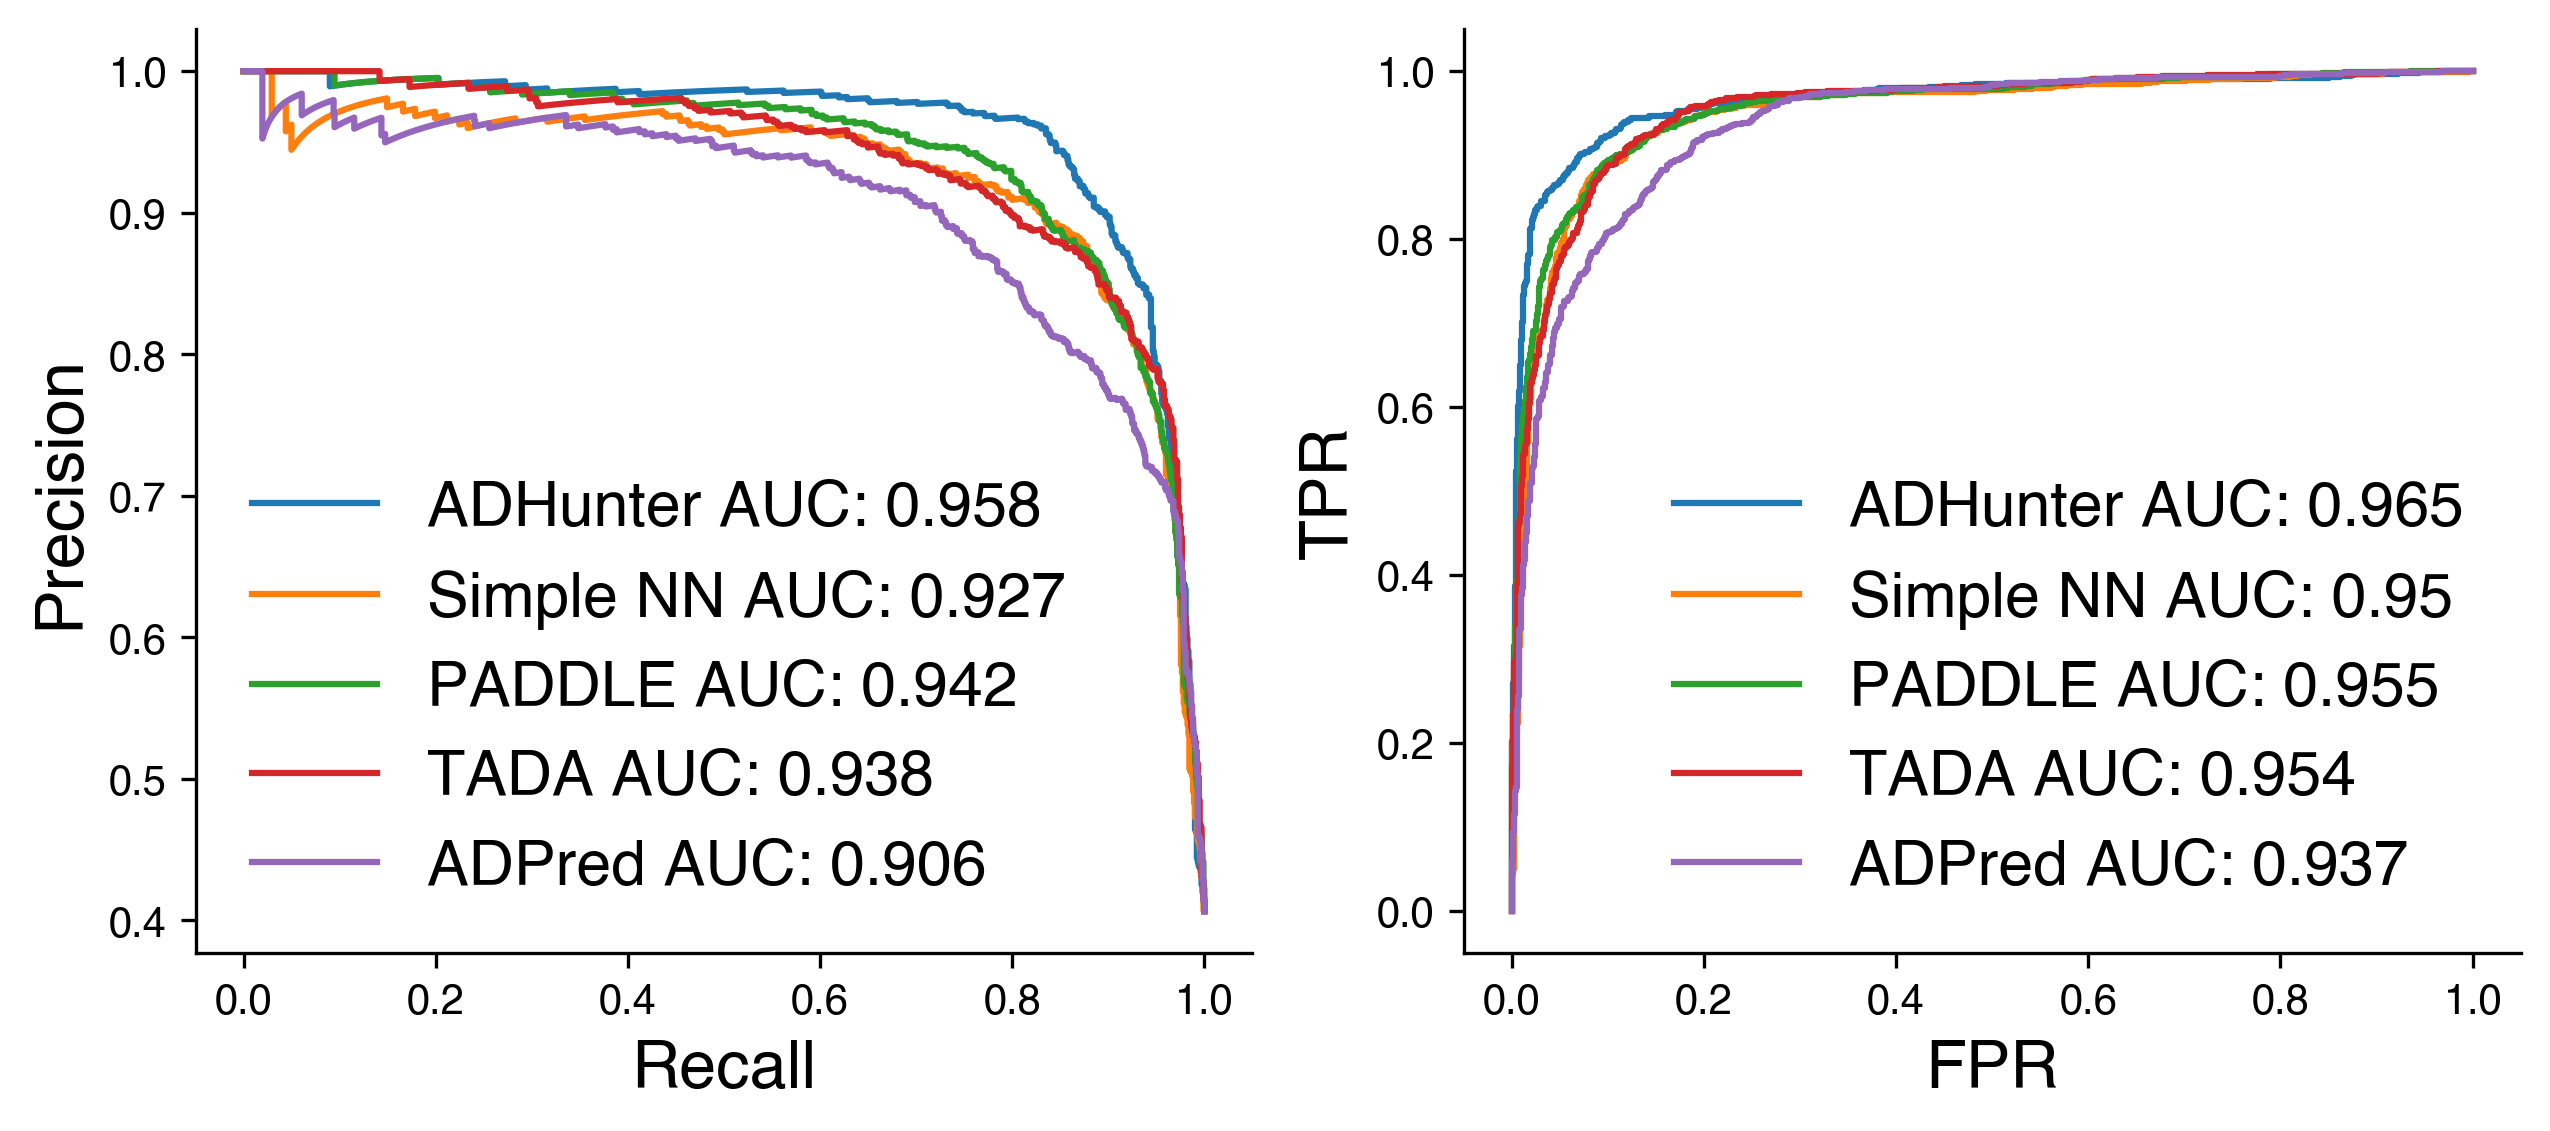

In [260]:
# Code to plot the PRC curves and the ROC curves

fig, axs = plt.subplots(1,2,figsize=(10,4))

# Get true labels (based on threshold of 2000)
experimental_measures = merged_preds["activity"]
experimental_labels = [i > 2000 for i in experimental_measures]

# Generating biophysical NN curves
biophysical_measures = merged_preds['biophysics_gfp_pred']
precision_b, recall_b, thresholds_b = precision_recall_curve(experimental_labels, biophysical_measures)
fpr_b, tpr_b, thresholds_b = roc_curve(experimental_labels, biophysical_measures)

# Generating PADDLE curves
paddle_measures = merged_preds['paddle_preds']
precision_p, recall_p, thresholds_p = precision_recall_curve(experimental_labels, paddle_measures)
fpr_p, tpr_p, thresholds_p = roc_curve(experimental_labels, paddle_measures)

# Generating ADHunter curves
adhunter_measures = merged_preds['adhunter_gfp_pred']
precision_a, recall_a, thresholds_a = precision_recall_curve(experimental_labels, adhunter_measures)
fpr_a, tpr_a, thresholds_a = roc_curve(experimental_labels, adhunter_measures)

# Generating TADA curves
tada_measures =  merged_preds['tada_preds']
precision_t, recall_t, thresholds_t = precision_recall_curve(experimental_labels, tada_measures)
fpr_t, tpr_t, thresholds_t = roc_curve(experimental_labels, tada_measures)

# Generating ADPred curves
adpred_measures = merged_preds['adpred_mean']
precision_ad, recall_ad, thresholds_ad = precision_recall_curve(experimental_labels, adpred_measures)
fpr_ad, tpr_ad, thresholds_ad = roc_curve(experimental_labels, adpred_measures)

# Calcualting AUCs for the PRC curves
biophysics_auc_pr = auc(recall_b, precision_b)
adhunter_auc_pr = auc(recall_a, precision_a)
paddle_auc_pr = auc(recall_p, precision_p)
tada_auc_pr = auc(recall_t, precision_t)
adpred_auc_pr = auc(recall_ad, precision_ad)

# Calcualting AUCs for the ROC curves
biophysics_auc_roc = auc(fpr_b, tpr_b)
adhunter_auc_roc = auc(fpr_a, tpr_a)
paddle_auc_roc = auc(fpr_p, tpr_p)
tada_auc_roc = auc(fpr_t, tpr_t)
adpred_auc_roc = auc(fpr_ad, tpr_ad)

# Plotting precision recall curves
axs[0].plot(recall_a, precision_a, label=f"ADHunter AUC: {adhunter_auc_pr:.3}")
axs[0].plot(recall_b, precision_b, label=f"Simple NN AUC: {biophysics_auc_pr:.3}")
axs[0].plot(recall_p, precision_p, label=f"PADDLE AUC: {paddle_auc_pr:.3}")
axs[0].plot(recall_t, precision_t, label=f"TADA AUC: {tada_auc_pr:.3}")
axs[0].plot(recall_ad, precision_ad, label=f"ADPred AUC: {adpred_auc_pr:.3}")

axs[0].legend(fontsize="15", frameon=False)
axs[0].set_xlabel("Recall", fontsize=16)
axs[0].set_ylabel("Precision", fontsize=16)

# Plotting ROC curves
axs[1].plot(fpr_a,tpr_a,  label=f"ADHunter AUC: {adhunter_auc_roc:.3}")
axs[1].plot(fpr_b, tpr_b, label=f"Simple NN AUC: {biophysics_auc_roc:.3}")
axs[1].plot(fpr_p, tpr_p, label=f"PADDLE AUC: {paddle_auc_roc:.3}")
axs[1].plot(fpr_t, tpr_t, label=f"TADA AUC: {tada_auc_roc:.3}")
axs[1].plot(fpr_ad, tpr_ad, label=f"ADPred AUC: {adpred_auc_roc:.3}")

axs[1].legend(fontsize="15", frameon=False)
axs[1].set_xlabel("FPR", fontsize=16)
axs[1].set_ylabel("TPR", fontsize=16)

sns.despine()
plt.savefig(f"figures/simple_AUC_plots_no_smooth.pdf", format='pdf', bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


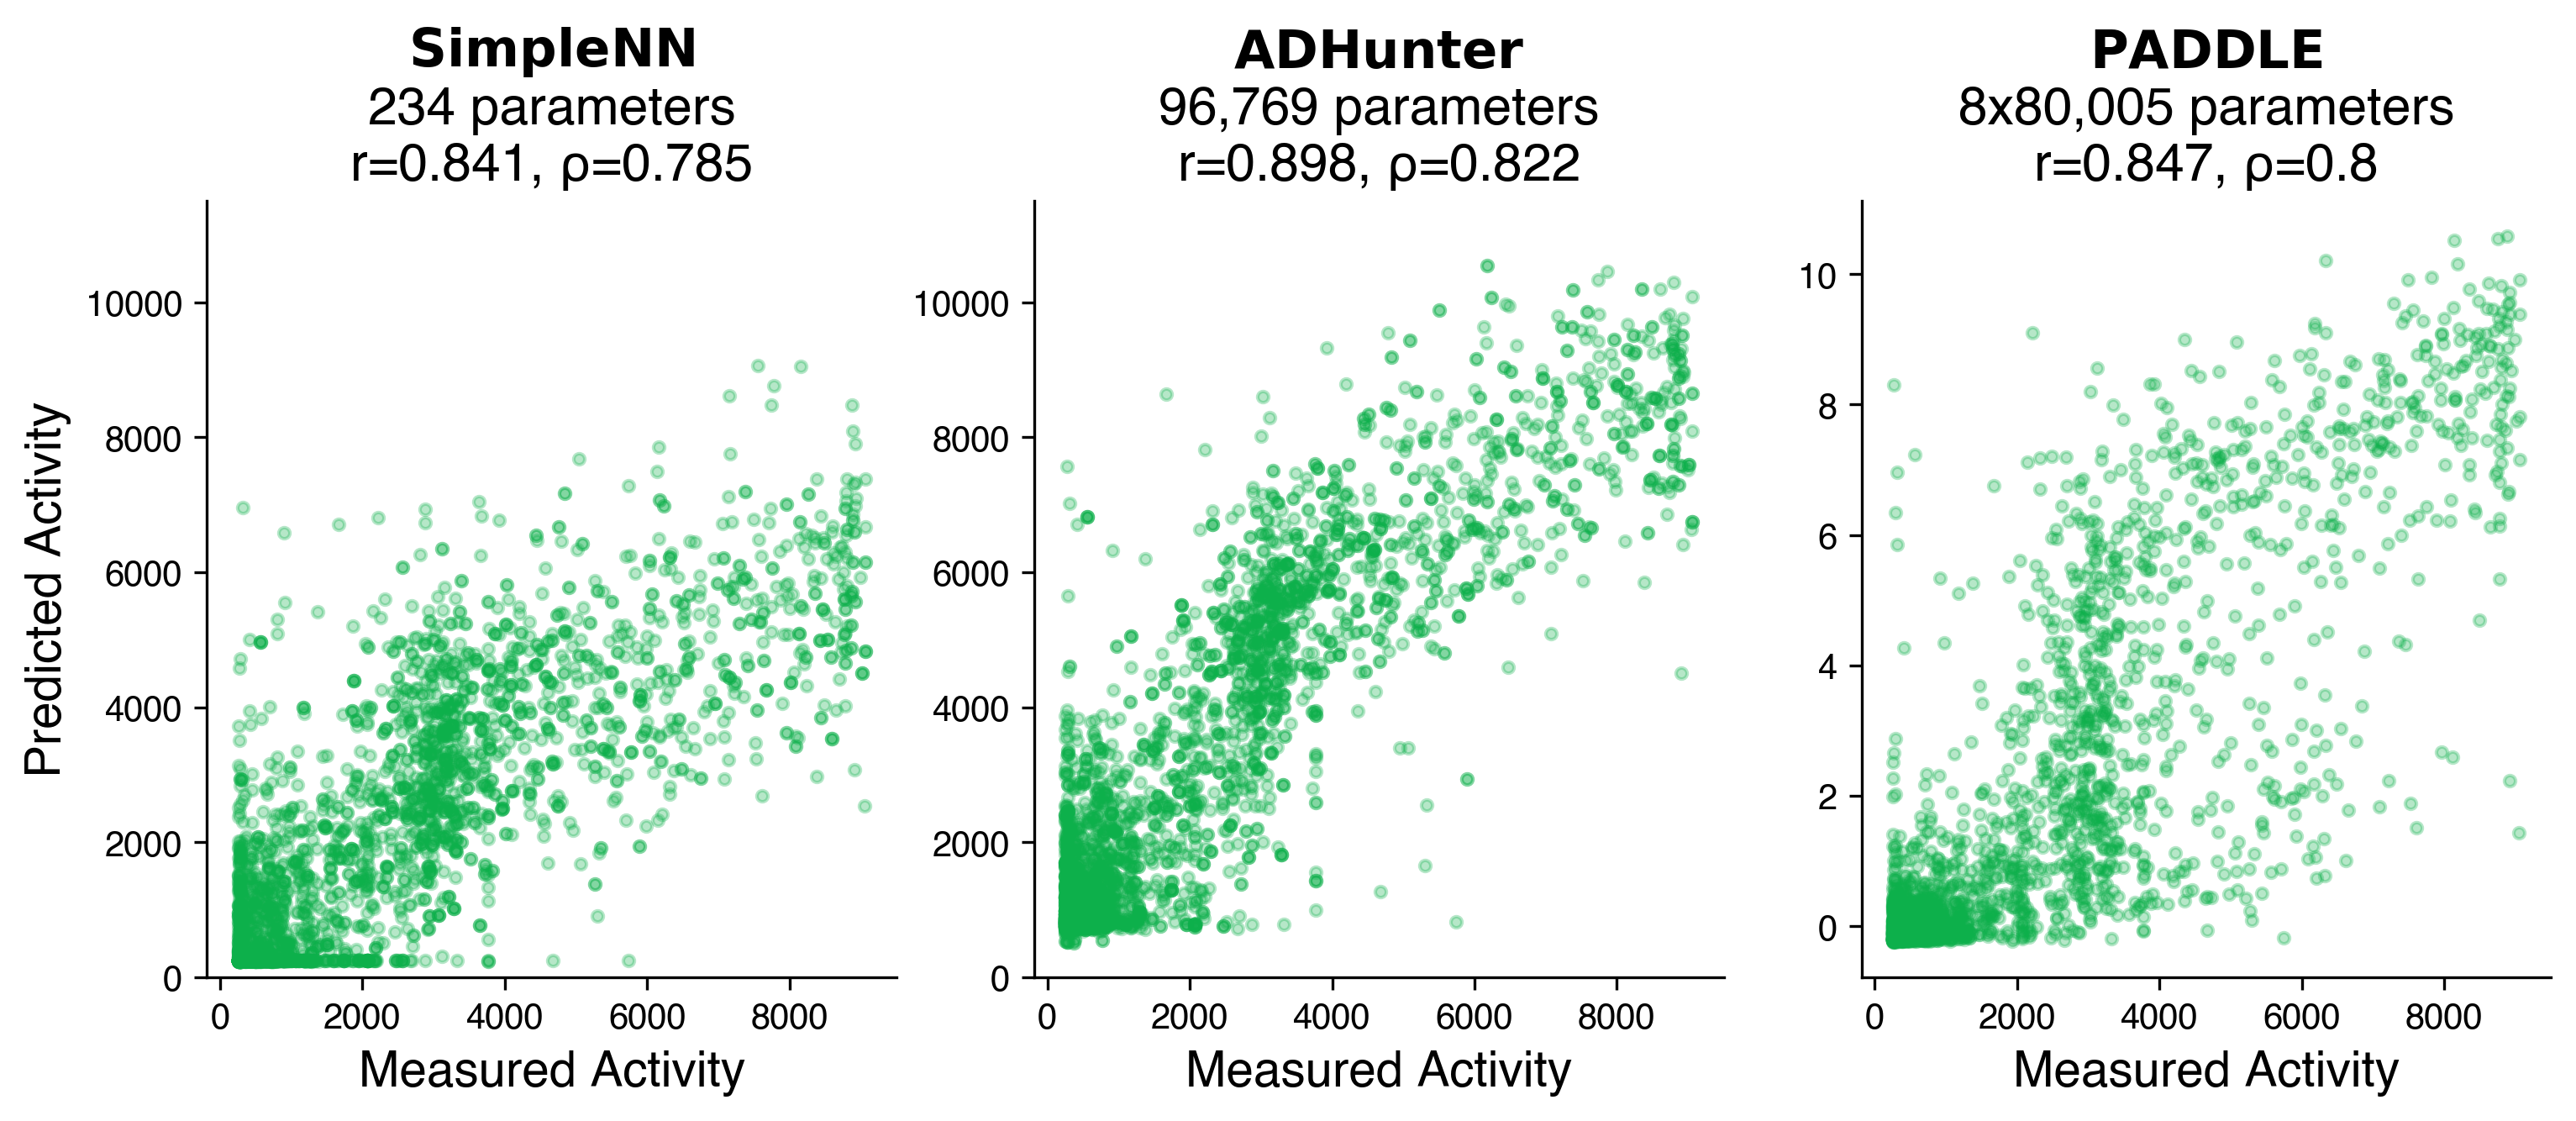

In [261]:
# Code to plot scatter plots for PADDLE, SimpleNN, and ADHunter

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig, axs = plt.subplots(1,3,figsize=(12,4))

# Scatter plot for SimpleNN
tiles = [i for ls in test_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"])) # Adding control tiles to test dataset
actual = [i for ls in test_seqs["40_tiles_exp_activities"] for i in ls]
actual = actual + (list(other_tiles["activity"]))
pred = [i for ls in test_seqs["biophysics_gfp_pred"] for i in ls]
pred = pred + (list(other_tiles["biophysics_gfp_pred"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") # Some tiles appear in multiple full length homologs

axs[0].scatter(actual, pred, color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"].astype(float), plotting_data["pred"].astype(float)).correlation
pearson = pearsonr(plotting_data["actual"].astype(float), plotting_data["pred"].astype(float)).correlation 
axs[0].set_xlabel('Measured Activity', fontsize=14)
axs[0].set_ylabel('Predicted Activity', fontsize=14)
axs[0].set_ylim(0, 11500)
axs[0].set_title(r"$\bf{SimpleNN}$" + f'\n{best_model_row.loc[0, " total_params"]} parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

# Scatter plot for ADHunter-GFP
tiles = [i for ls in test_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"])) # Adding control tiles to test dataset
actual = [i for ls in test_seqs["40_tiles_exp_activities"] for i in ls]
actual = actual + (list(other_tiles["activity"]))
pred = [i for ls in test_seqs["adhunter_gfp_pred"] for i in ls]
pred = pred + (list(other_tiles["adhunter_gfp_pred"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") # Some tiles appear in multiple full length homologs

axs[1].scatter(actual, pred, color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"].astype(float), plotting_data["pred"].astype(float)).correlation
pearson = pearsonr(plotting_data["actual"].astype(float), plotting_data["pred"].astype(float)).correlation 
axs[1].set_xlabel('Measured Activity', fontsize=14)
axs[1].set_ylim(0, 11500)
axs[1].set_title(r"$\bf{ADHunter}$" + f'\n96,769 parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

sns.despine()

# Scatter plot for PADDLE
axs[2].scatter(merged_preds["activity"], merged_preds['paddle_preds'], color='#0DB04B', s=10, alpha=0.3)
spearman = spearmanr(merged_preds["activity"], merged_preds['paddle_preds']).correlation
pearson = pearsonr(merged_preds["activity"], merged_preds['paddle_preds']).correlation 
axs[2].set_xlabel('Measured Activity', fontsize=14)
axs[2].set_title(r"$\bf{PADDLE}$" + f'\n8x80,005 parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

sns.despine()
plt.savefig("figures/simple_activity_scatter_plots_w_PADDLE.pdf", format='pdf', bbox_inches='tight')

# Inspecting the parameters of the model

In [ ]:
# Order of AAs for plotting
amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

def get_conv_weights(model, layer): 
    """
    Extracts the convolutional layer weights and
    returns them as a pandas dataframe
    """
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer, kernel_size):
    """
    Extracts the linear layer weights and
    returns them as a numpy array. Also returns the 
    corresponding x-axis values
    """
    linear_weights = (40 - kernel_size + 1)
    model_state_dict = model.state_dict()
    linear_weight = model_state_dict[layer].detach().numpy().reshape(linear_weights)
    x_vals = np.array(range(0,linear_weights))
    return linear_weight, x_vals


In [ ]:
# This is setting up our colors for the plots

# Colors for convolutional filter
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Blue, White, Red
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any

# Colors for AA labels
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [ ]:
def make_row_plot(fig, kernel_size, model, row, lim, height_ratios, num_rows):
    """
    Core functionality for creating the convolutional filter plots. 
    Plots the convolution filter as a heatmap and the linear weights as a bar plot.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure object created with plt.figure
    
    kernel_size : int
        The size of the convolutional filter

    model : ADModel_abund
        Loaded model (from which parameters will be extracted)
    
    row : int
        Which row in the overall figure should we fill in

    lim : float
        The max value for the heatmap

    height_ratios : list
        Ratio of heights between rows, length should correspond to number of rows in
        gridspec object

    num_rows : list
        The number of rows in the gridspec object

    Returns
    -------
    ax1 : maplotlib.Axes object
        Contains the heatmap
    ax2 : maplotlib.Axes object
        Contains the barplot
    im1 : maplotlib.Axes.imshow object
        The heatmap
    """

    # Load the convolutional and linear weights
    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    # Calculate how much of the figure the convolutional filter vs. linear weights will take up
    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1

    # GridSpec allows us to plot rows/columns with different dimensions
    # Here, we initalize the gridspec object with the total number of rows in our figure
    # But we only fill in the specific row that we are interested in
    # (When combined with many other gridspec objects, they will all line up and look good)
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)
   
    # ax1 and ax2 are matplotlib axes
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    # This is the code for plotting the convolutional filter as a heatmap
    # Min and max values of heatmap are passed by used
    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))

    # This is to color the amino acid labels
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 

    # This is the code for plotting the linear weights as a bar graph
    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)

    ax2.spines['bottom'].set_bounds(min(model_xvals1) - 1, max(model_xvals1) + 1)
    
    # Remove all x-ticks for the bargraph
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    return ax1, ax2, im1

In [ ]:
def load_model(file, kernel_size):
    """
    Loads a SimpleNN-GFP model.
    """
    model = ADModel_act(size,kernel_size)
    model.load_state_dict(torch.load(f"{file}.pth"))

    model.eval()
    return model

In [ ]:
# Get another high performing model to display
best_models = model_results.sort_values("sum_rank").drop_duplicates(" kernel_size", keep='first')
file = best_models[best_models[' kernel_size'] == 40]["model_name"].values[0].removeprefix("../../") 
model_40 = load_model(file, 40)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


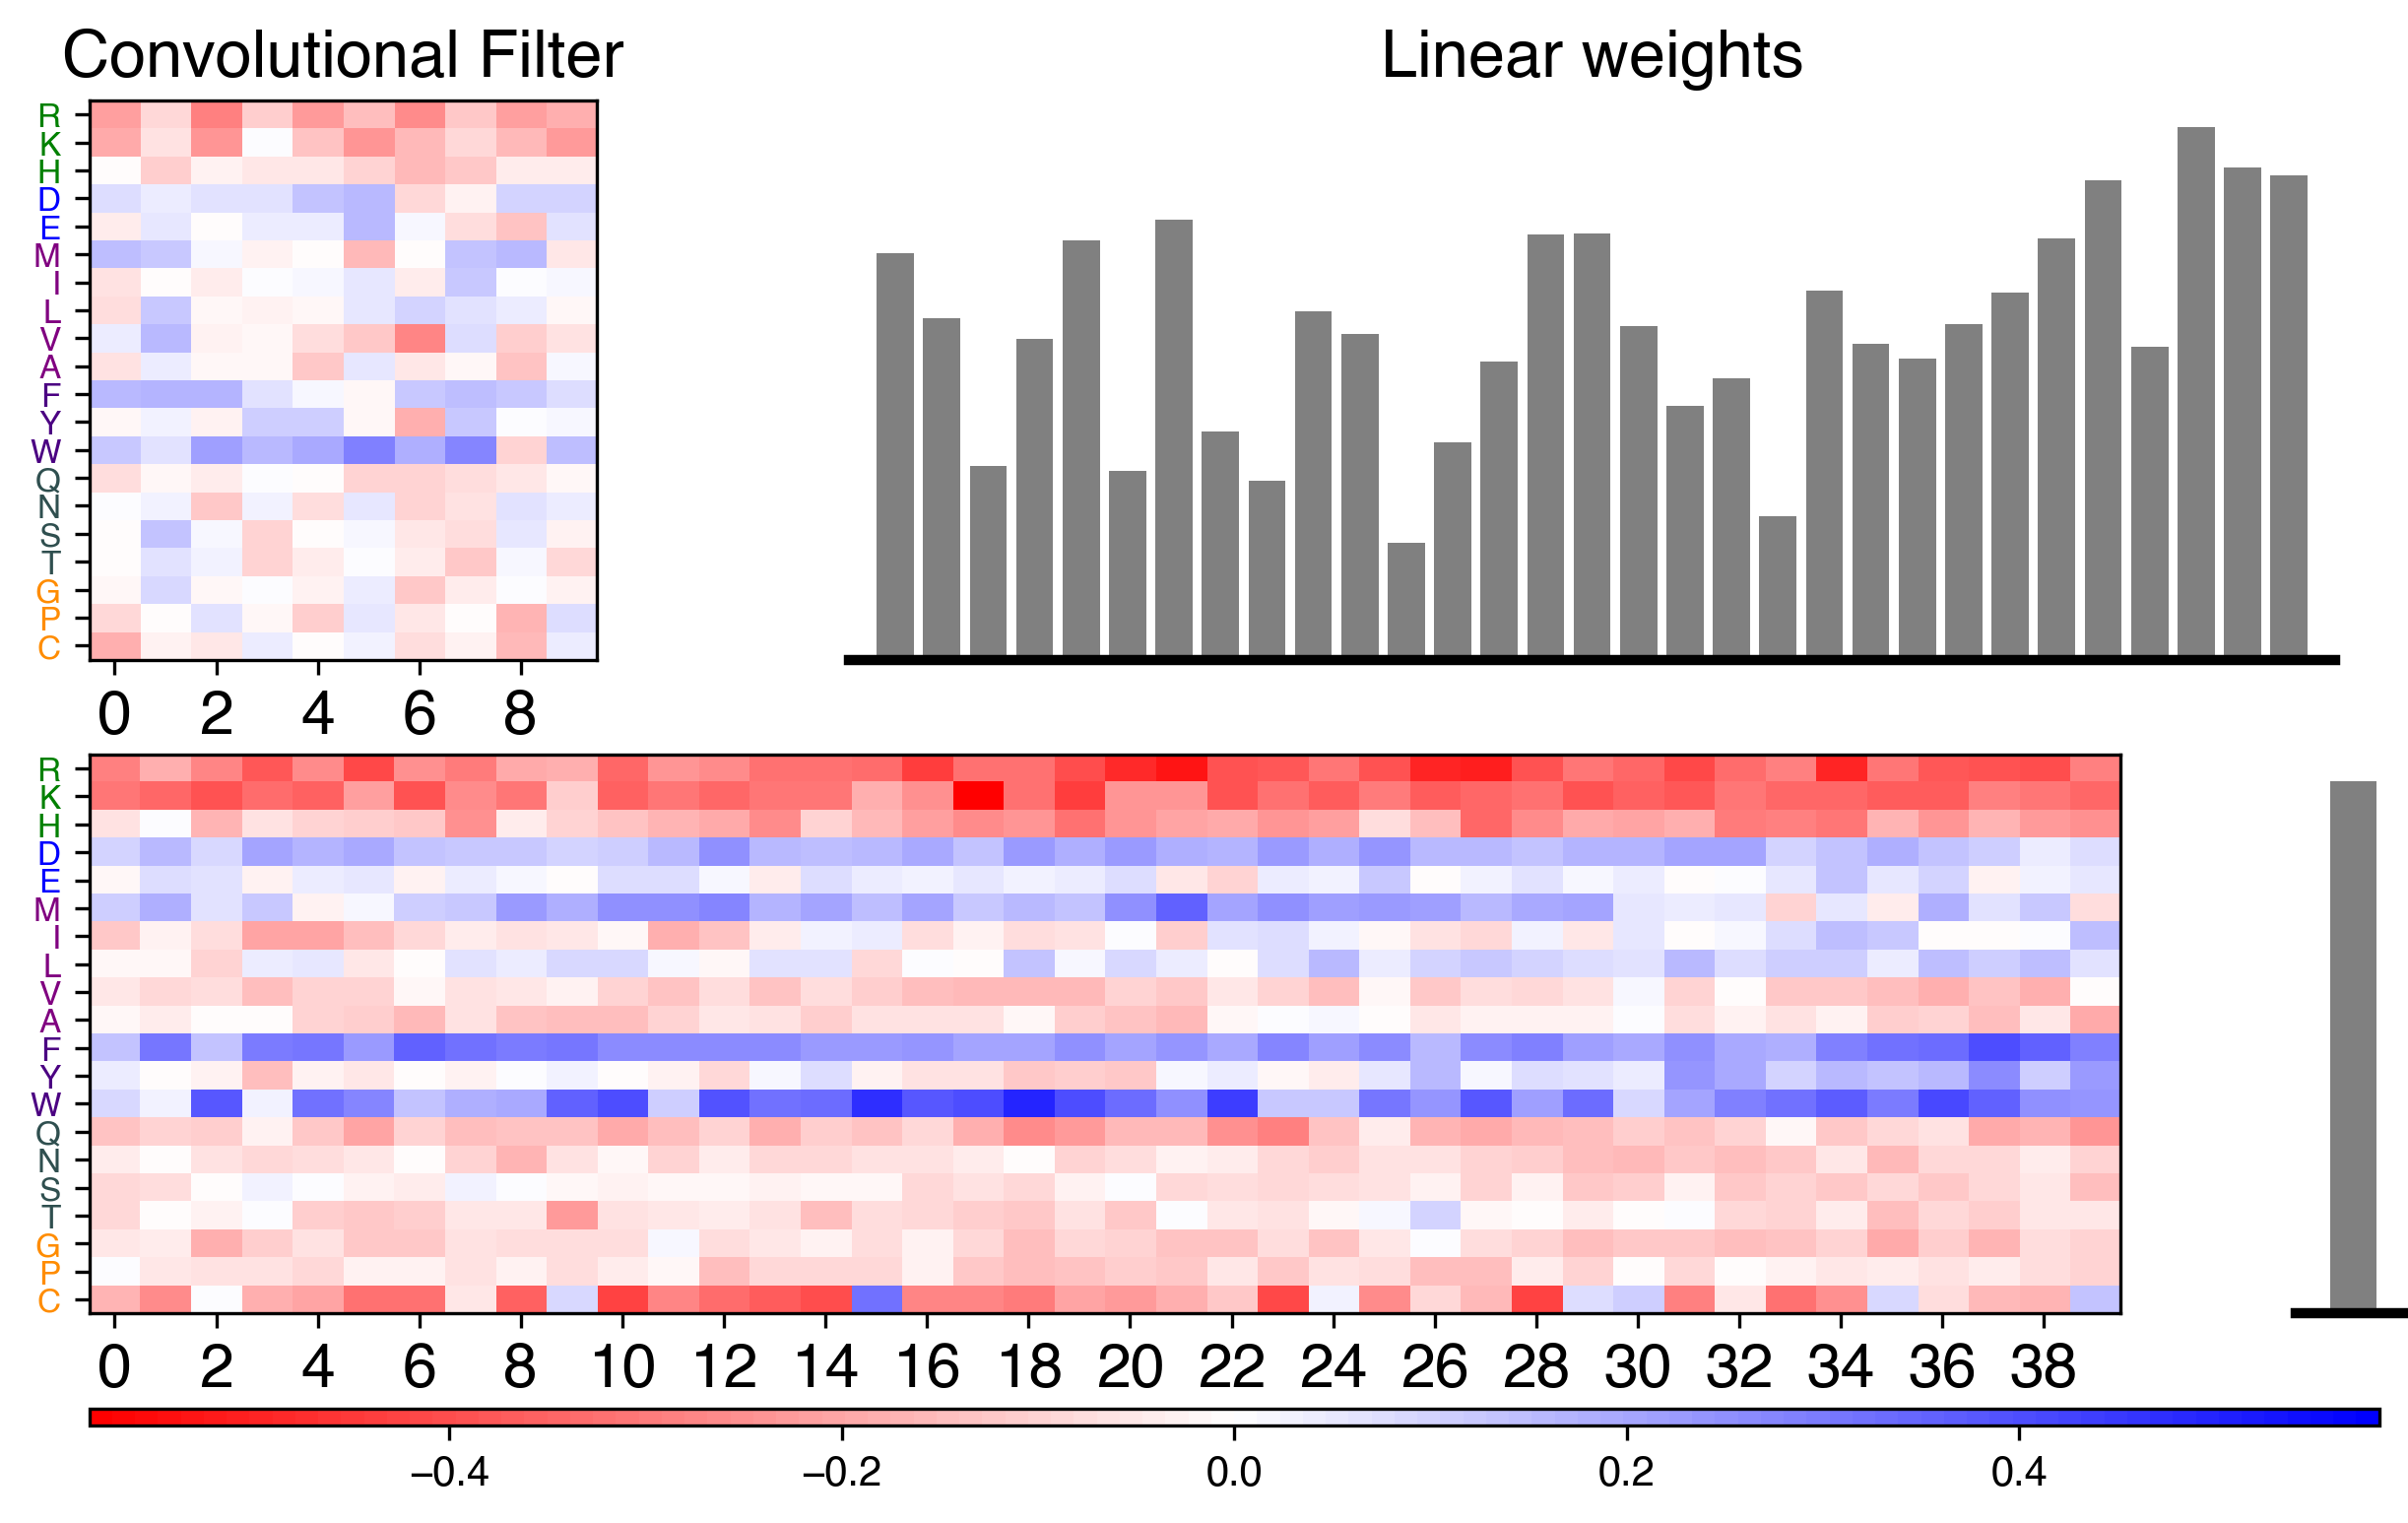

In [282]:
num_rows = 2

# Get the range for the heatmaps
models = [biophysical_model, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))

# We add in "padding" rows between the rows we care about
height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

# Create a gridspec object
gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)

# Adding the best NN parameters to the first row
ax1, ax2, im1 = make_row_plot(fig, kernel_size, biophysical_model, 1, lim, height_ratios, num_rows)

ax1.set_title("Convolutional Filter", fontsize=16)
ax2.set_title("Linear weights", fontsize=16)

# Adding another NN parameters to the second row (row 3 because of padding)
make_row_plot(fig, 40, model_40, 3, lim, height_ratios, num_rows)

# Create another gridspec object to span the whole figure (1 column) to display the colorbar
gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("figures/simple_activity_parameters.pdf", format='pdf', bbox_inches='tight')


# Make plot for all filters

In [ ]:
# Load the best model at each filter size 

best_models = model_results.sort_values("sum_rank").drop_duplicates(" kernel_size", keep='first')

# Best size 5 kernel
file = best_models[best_models[' kernel_size'] == 5]["model_name"].values[0].removeprefix("../../") 
model_5 = load_model(file, 5)

# Best size 10 kernel
file = best_models[best_models[' kernel_size'] == 10]["model_name"].values[0].removeprefix("../../") 
model_10 = load_model(file, 10)

# Best size 15 kernel
file = best_models[best_models[' kernel_size'] == 15]["model_name"].values[0].removeprefix("../../") 
model_15 = load_model(file, 15)

# Best size 20 kernel
file = file = best_models[best_models[' kernel_size'] == 20]["model_name"].values[0].removeprefix("../../") 
model_20 = load_model(file, 20)

# Best size 30 kernel
file = best_models[best_models[' kernel_size'] == 30]["model_name"].values[0].removeprefix("../../") 
model_30 = load_model(file, 30)

# Best size 40 kernel 
file = best_models[best_models[' kernel_size'] == 40]["model_name"].values[0].removeprefix("../../") 
model_40 = load_model(file, 40)


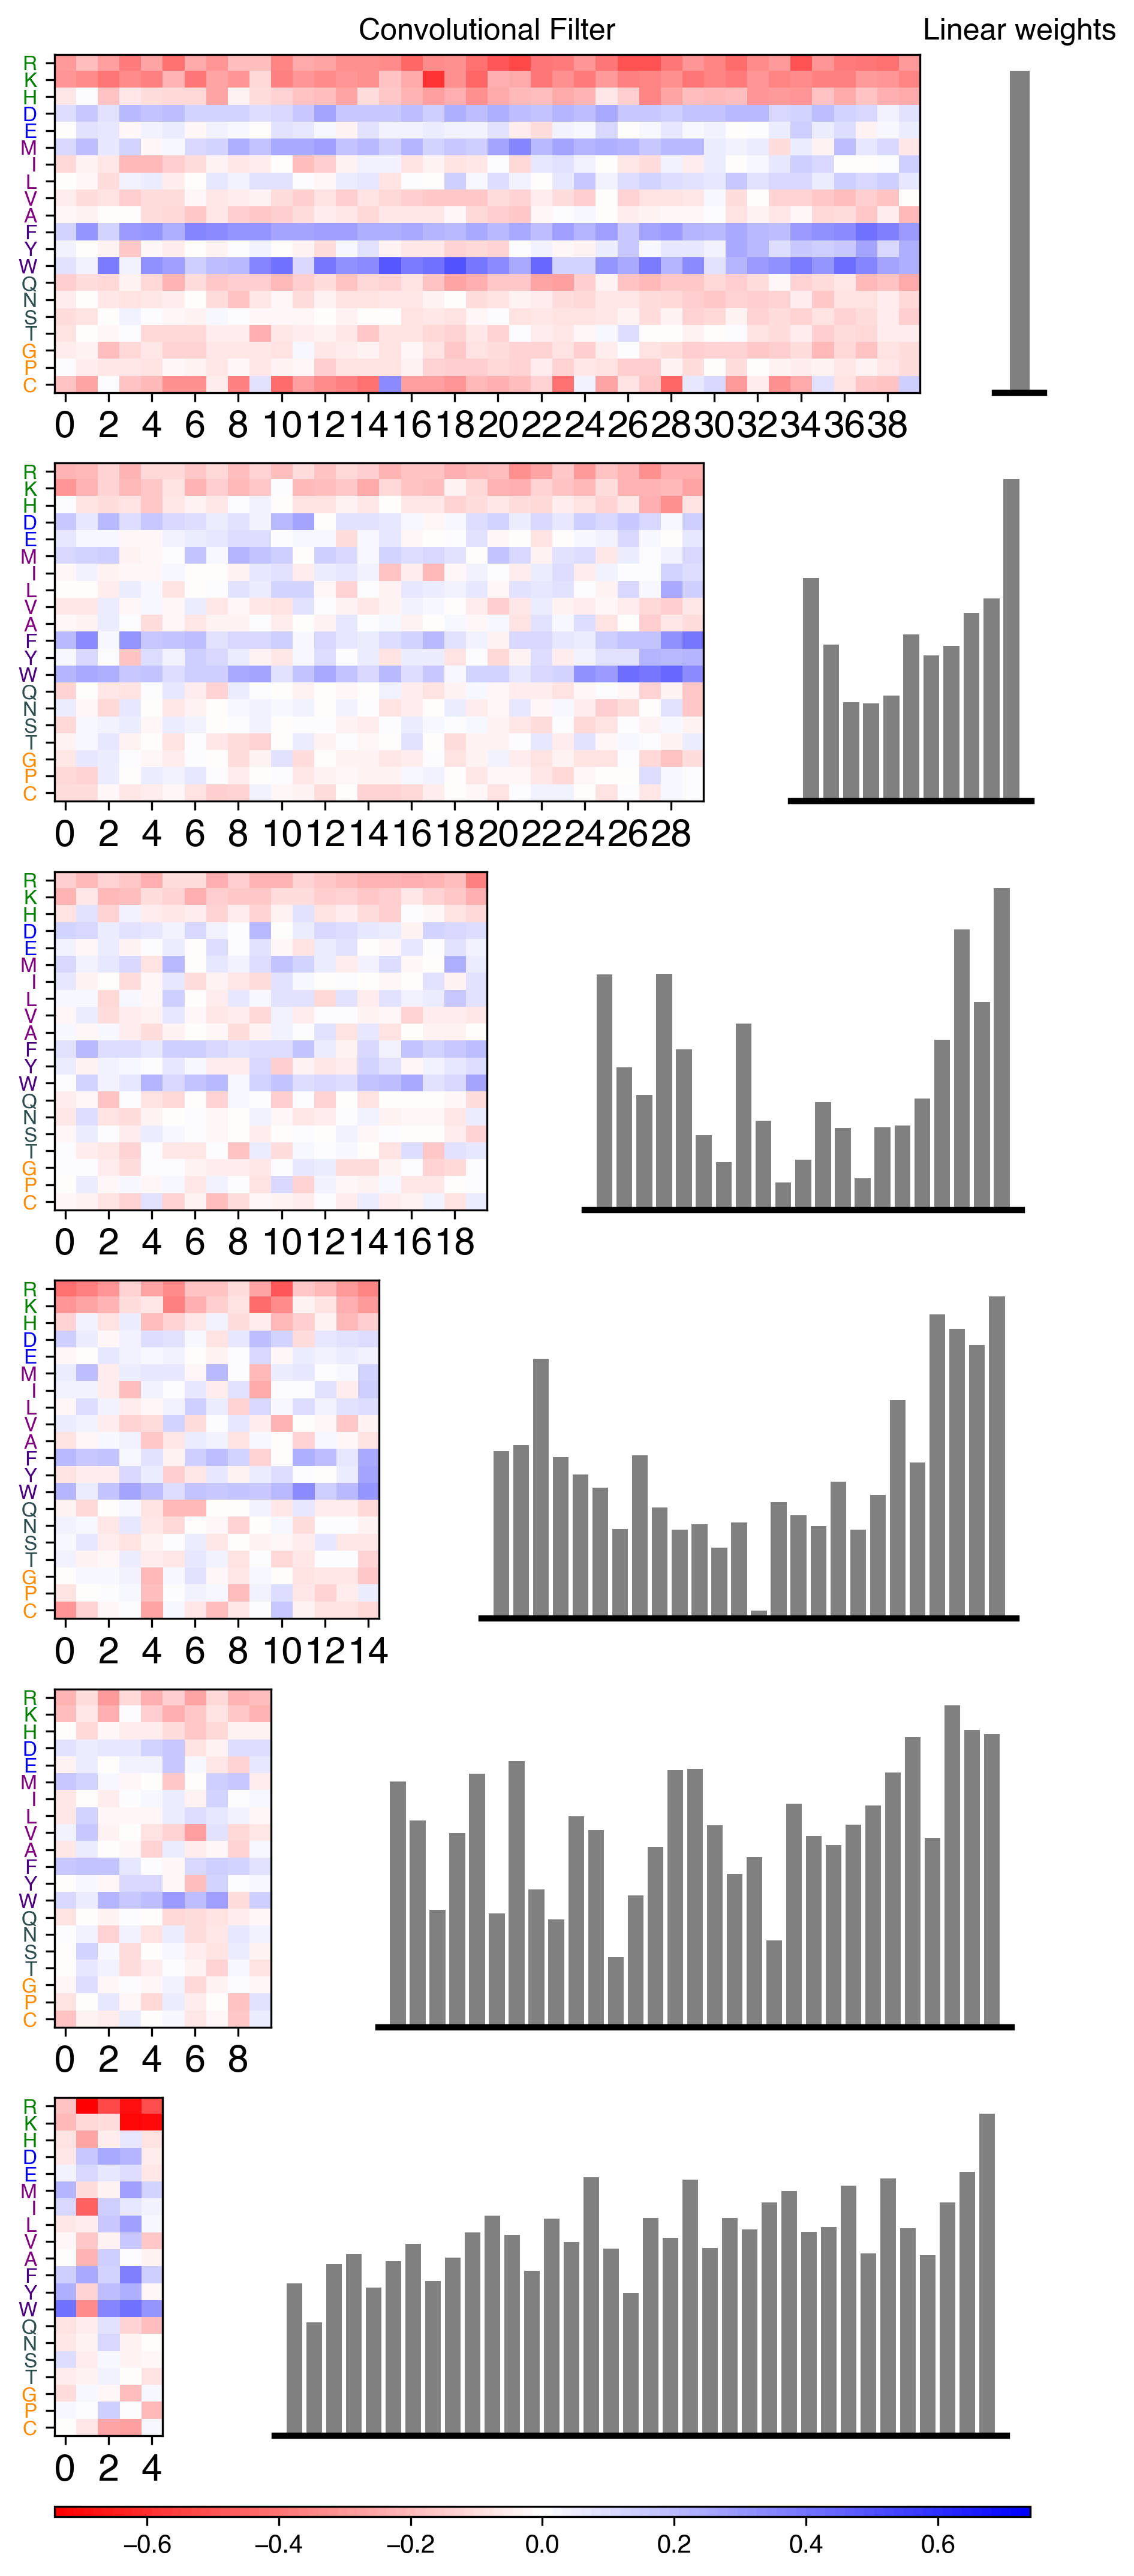

In [283]:
num_rows = 6

# Get the range for the heatmaps
models = [model_5, model_10, model_15, model_20, model_30, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(7, 3*num_rows))

# We add in "padding" rows between the rows we care about
height_ratios = [.01] + [3.3, .1]*num_rows + [.1]

# Create a gridspec object
gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)

# Adding the size 40 NN parameters to the first row
ax1, ax2, im1 = make_row_plot(fig, 40, model_40, 1, lim, height_ratios, num_rows)

# Add titles to the first row
ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

# Adding the other NN parameters (row count increases by 2 because of padding)
make_row_plot(fig, 30, model_30, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 20, model_20, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 15, model_15, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 10, model_10, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 5, model_5, 11, lim, height_ratios, num_rows)

# Create another gridspec object to span the whole figure (1 column) to display the colorbar
gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')

# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.pdf', dpi=1000, bbox_inches='tight')
# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.png', dpi=1000, bbox_inches='tight')